In [190]:
# This notebook can be used to analyze a model. ANY model. We are just going to 
# load this model on up, then run the validation data through it, and get make a nice confusion matrix
# from the results :)
#
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, model_from_json
from keras import backend as K 
from keras.layers import Dropout, Flatten, Dense

import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import imageio as io

###################################################
# You put the file names in here                  #
#                                                 #
json_file = 'VGG19_transfer[m1]_3.json'
weight_file_name = 'VGG19_transfer[m1]_3.h5'
test_dir = './cropped_split_dataset/test'



####################################################
# And you put the model architecture info here     #
#                                                  #
loss = 'categorical_crossentropy'
num_units_first_dense = 986 
dropout_rate = 0.3867433627389078
num_units_second_dense = 1043
lr = 0.006072113068495087
momentum = 0.7963386502886618



####################################################
#       Where the magic happens                    #
#                                                  #  
model_json = open('./models_json/' + json_file, 'r')
loaded_model_json = model_json.read()
model_json.close()
model = model_from_json(loaded_model_json)
print('Model loaded from json...')

l = model.output
l = Flatten()(l)
l = Dense(num_units_first_dense, activation='relu')(l)
l = Dropout(dropout_rate)(l)
l = Dense(num_units_second_dense, activation='relu')(l)
final = Dense(2, activation='softmax')(l)
model = Model(inputs=model.input, outputs=final)
print('Extra layers of model added')

weight_file = './weights/' + weight_file_name
model.load_weights(weight_file)
print('Model weights loaded from disk...')

model.compile(
     loss=loss,
     optimizer=optimizers.SGD(lr=lr, momentum=momentum),
     metrics=['accuracy'])
print('Model Compiled')

model.summary()

Model loaded from json...
Extra layers of model added
Model weights loaded from disk...
Model Compiled
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_______________________________________

In [191]:
# Here is where we do the predictions and evaluations
#
img_height, img_width = 128, 128

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=(img_height, img_width),
        class_mode='categorical')

predictions = model.predict_generator(test_generator, use_multiprocessing=True)
evaluations = model.evaluate_generator(test_generator, use_multiprocessing=True)

Found 11878 images belonging to 2 classes.


In [192]:
print('Performance of evaluation')
print(model.metrics_names)
print(evaluations)  # 96.9 accuracy Boiiiiii

Performance of evaluation
['loss', 'acc']
[0.07753530068310942, 0.969439299545378]


In [193]:
# Taken from scikit learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2723   78]
 [ 285 8792]]
Normalized confusion matrix
[[0.97 0.03]
 [0.03 0.97]]


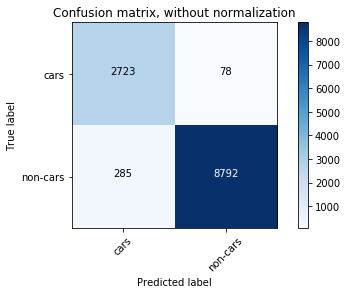

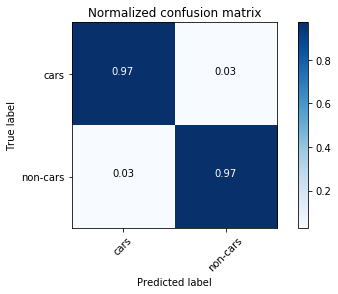

In [194]:
# Now to makea confusion matrix so that we can see some more precise 
# performance statistics
y_true = validation_generator.classes
y_pred = np.argmax(predictions, axis=-1)

# Compute confusion matrix
# Plot non-normalized  && normalized confusion matrices
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
class_names = ['cars', 'non-cars']


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [195]:
# DELIVERABLES 
#    1.) Cool visualizations of key layers                                            [CHECK] 
#        - The re-trained conv layers (maybe before & after)
#        - Exploration of which layers ARE key layers of VGG/show them
#
#    2.) Output all false negative vehicles/false positive vehicles into directories  [CHECK ISH]
#        and analyze them
#        - Visualizing activations at key layers when put in
#        - Perform Human-level search for common undetected features
#        - Possibly heatmaps? 
#
#    3.) Find top 5 images which cause highest activations--both for the car and the  [     ] 
#        non-car class
#
#    4.) Get performance statistics and confusion matrices for the trained model      [CHECK] 
#

In [ ]:
# Here we will identify all images which are misclassified, and write them to a directory 
#    
# Current Thoughts: Iterate over batches in validation_generator, 
#                     - Round output predictions to nearest integer 
#                     - Compare output with GT to see if mis-classified 
#                        * Check if it was a CAR false-negative (gt == car, pred == non-car)  
#                            Output image data to ./analyze/car directory
#                        * Else it was a non-car classified as a car 
#                            Output image data to ./analyze/non-car directory
tdg = ImageDataGenerator(rescale=1./255)
t_gen = tdg.flow_from_directory(
        test_dir,
        batch_size=1,
        shuffle=False,
        target_size=(img_height, img_width),
        class_mode='categorical')

count = 0


for i, batch in enumerate(t_gen):
    gt = np.argmax(batch[1]) # Confident in this
    pred = np.argmax(model.predict_on_batch(batch[0]))
    
    if gt != pred:
        count = count + 1
        print('Epoch: ' + str(i) + '  count: ' + str(count))
    
        if gt == 0:
            io.imwrite('./analyze/car_false_neg/img' + str(count) + '.jpg', batch[0][0])   
        else:   
            io.imwrite('./analyze/non_car_false_pos/img' + str(count) + '.jpg', batch[0][0])   
    
    # For some reason, the generator can be enumerated over for longer than the total number of 
    # images in the directory... Possibly some interaction between the enumerate & keras classes. 
    if i > 11878:
        break
    

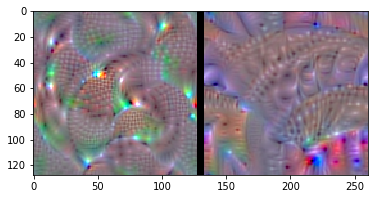

In [228]:
# Here we are going to do some exploration with visualizing the actual layers of the network
#
# Here's the layer names:
# ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 
#  'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 
#  'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool', 'flatten_13',
#  'dense_37', 'dropout_13', 'dense_38', 'dense_39']
#
from keras import activations
from vis.utils import utils
from vis.visualization import visualize_activation
from vis.input_modifiers import Jitter

layer_names = [m.name for m in model.layers]

# We need to swap the softmax activation with a linear activation for some reason which is unclear to me,
# but which was in the keras-vis docs. Has to do with allowing proper gradient flow
pred_index = utils.find_layer_idx(model, 'dense_39')
model.layers[pred_index].activation = activations.linear
model = utils.apply_modifications(model)


# Here we are using the "visualize_activation" method to create a "maximally activating" input image for the 
# car class (indicated by the "filter_indices=0" param)
imgs = []
imgs.append(visualize_activation(model, pred_index, filter_indices=0, max_iter=500, input_modifiers=[Jitter(16)]))
imgs.append(visualize_activation(model, pred_index, filter_indices=1, max_iter=500, input_modifiers=[Jitter(16)]))

plt.imshow(utils.stitch_images(imgs, cols=2))
plt.show()
